In [107]:
### This program requires a local installation of APACHE SPARK to run

# conda install -c anaconda seaborn
# conda install -c anaconda py-xgboost

# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor(..., tree_method='gpu_hist')
# from sklearn.metrics import mean_squared_error
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

# Version 2 Revenue Prediction:
# USES NEURAL NETWORK TO PREDICT REVENUE FROM COUNTRY, CHANNEL, OPERATOR, and REQUESTED POD DURATION

# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

import findspark
# Start Spark Session
findspark.init('C:\Spark\spark-3.2.2-bin-hadoop2.7')
import pyspark
from pyspark import SparkFiles
from pyspark.sql.functions import to_date, to_timestamp
from getpass import getpass


# Build Spark Session
### IMPORTANT: MAKE SURE THAT spark.config has memory set to 32GB or larger!
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Qwest-Analytics-Dashboard-and-ML-Model").config("spark.jars", "C:\Spark\spark-3.2.2-bin-hadoop2.7\jars\postgresql-42.5.0.jar").getOrCreate()

IMPORT DATA AND CLEAN FOR ML

In [108]:
### THIS IS THE FINAL DATABASE PULL ###

# Connecting to database and exporting data

#Store environmental variables
password = getpass('Enter DataBase Password: ')

#Configure for RDS
jdbc_url="jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database"
config = {"user":"postgres", 
          "password": password, 
          "driver":"org.postgresql.Driver"}

# Load the advertising_data.csv which contains features and fill rate
advertising_data_df = spark.read.format("jdbc").options(
         url= jdbc_url,
         dbtable='cleaned_advertising_data',
         user='postgres',
         password=password,
         driver='org.postgresql.Driver').load()

advertising_data_df.show()
advertising_data_df.printSchema()

# load viewership data
viewership_data_df = spark.read.format("jdbc").options(
         url= jdbc_url,
         dbtable='cleaned_viewership_data',
         user='postgres',
         password=password,
         driver='org.postgresql.Driver').load()

viewership_data_df.show()
viewership_data_df.printSchema()

# load viewership mapping data
mapping_df = spark.read.format("jdbc").options(
         url= jdbc_url,
         dbtable='viewership_channels_mapping_table',
         user='postgres',
         password=password,
         driver='org.postgresql.Driver').load()

mapping_df.show()
mapping_df.printSchema()





+----------+--------------+-------------+--------+-----------+-------------+-----------------+------------+-------------+--------+-----------+-------+------------------+----------------------+----------------------+-------------------+--------------------+----------------------+
|      date|       country|       region|operator|    channel|pod_fill_rate|endpoint_requests|bid_requests|bid_responses|bid_wons|impressions|revenue|               cpm|requested_pod_duration|requested_pod_droprate|filled_pod_duration| filled_pod_droprate|delivered_pod_duration|
+----------+--------------+-------------+--------+-----------+-------------+-----------------+------------+-------------+--------+-----------+-------+------------------+----------------------+----------------------+-------------------+--------------------+----------------------+
|2022-08-23|        Mexico|North America|  Op_002|Channel_002|         0.15|             8268|      714194|        63542|   14936|       6268|  25.16| 4.0140395

In [125]:
advertising_data_df_pd = advertising_data_df.toPandas()
advertising_data_df_pd['date'] = advertising_data_df_pd['date'].apply(pd.to_datetime)
advertising_data_df_pd

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,impressions,revenue,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration
0,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,6268,25.16,4.014040,177.60,-0.644707,63.10,-0.576862,26.70
1,2022-08-23,United States,North America,Unknown,Unknown,0.25,36,5040,327,51,39,0.51,13.076923,305.01,-0.631160,112.50,-0.333333,75.00
2,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,69,0.36,5.217391,272.76,-0.998680,0.36,-0.500000,0.18
3,2022-08-23,South Korea,Asia,Op_002,Channel_003,0.00,2,228,12,0,0,0.00,0.000000,90.00,-1.000000,0.00,NaN,0.00
4,2022-08-23,India,Asia,Op_002,Channel_003,0.00,3,384,0,0,0,0.00,0.000000,360.00,-1.000000,0.00,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41175,2022-08-22,Spain,Europe,Op_003,Channel_003,0.00,342,52635,2727,0,0,0.00,0.000000,366.00,-1.000000,0.00,NaN,0.00
41176,2022-08-22,France,Europe,Op_003,Channel_003,0.00,70,11858,1114,0,0,0.00,0.000000,244.00,-1.000000,0.00,NaN,0.00
41177,2022-08-22,Germany,Europe,Op_003,Channel_003,0.00,36,5868,321,12,0,0.00,0.000000,366.00,-0.944672,20.25,-1.000000,0.00
41178,2022-08-22,Italy,Europe,Op_003,Channel_003,0.00,18,3654,153,9,0,0.00,0.000000,366.00,-0.938525,22.50,-1.000000,0.00


In [126]:
viewership_data_df_pd = viewership_data_df.toPandas()
viewership_data_df_pd['session_count'] = viewership_data_df_pd['session_count'].astype(int)
viewership_data_df_pd['total_viewership_seconds'] = viewership_data_df_pd['total_viewership_seconds'].astype(int)
viewership_data_df_pd['unique_viewers'] = viewership_data_df_pd['unique_viewers'].astype(int)
viewership_data_df_pd['date'] = viewership_data_df_pd['date'].apply(pd.to_datetime)
viewership_data_df_pd

,date,feed_name,country,device_type,session_count,total_viewership_seconds,unique_viewers,region
0,2022-04-30,Feed_012,Germany,Mobile Phone,2,65,2,Europe
1,2022-04-30,Feed_012,Greece,Mobile Phone,1,67,1,Europe
2,2022-04-30,Feed_012,Hungary,Mobile Phone,1,78,1,Europe
3,2022-04-30,Feed_012,Ireland,Mobile Phone,1,188,1,Europe
4,2022-04-30,Feed_012,Italy,Mobile Phone,4,128,4,Europe
...,...,...,...,...,...,...,...,...
675287,2021-11-05,Feed_002,Isle of Man,Smart TV,1,126,1,Europe
675288,2021-11-05,Feed_002,Israel,Smart TV,1,127,1,Asia
675289,2021-11-05,Feed_002,Italy,Smart TV,18622,1479786,12849,Europe
675290,2021-11-05,Feed_002,Jersey,Smart TV,1,61,1,Europe


In [127]:
mapping_df_pd = mapping_df.toPandas()
mapping_df_pd

,feed_name,channel,operator
0,Feed_001,Channel_003,Op_001
1,Feed_002,Channel_003,Op_002
2,Feed_003,Channel_001,Op_001
3,Feed_004,Channel_001,Op_002
4,Feed_005,Channel_002,Op_002
...,...,...,...
70,Feed_071,Channel_001,Op_006
71,Feed_072,Channel_002,Op_006
72,Feed_073,Channel_003,Op_011
73,Feed_074,Channel_001,Op_011


In [128]:
merged_mapping_viewership = viewership_data_df_pd.merge(mapping_df_pd, left_on='feed_name', right_on = 'feed_name' )
merged_mapping_viewership['date'] = merged_mapping_viewership['date'].apply(pd.to_datetime)
merged_mapping_viewership = merged_mapping_viewership.drop('device_type', 1)
merged_mapping_viewership = merged_mapping_viewership.groupby(['date', 'country', 'feed_name', 'region', 'channel', 'operator'])['session_count', 'total_viewership_seconds', 'unique_viewers'].sum().reset_index()

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_31604\1556885118.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged_mapping_viewership = merged_mapping_viewership.drop('device_type', 1)
C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_31604\1556885118.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_mapping_viewership = merged_mapping_viewership.groupby(['date', 'country', 'feed_name', 'region', 'channel', 'operator'])['session_count', 'total_viewership_seconds', 'unique_viewers'].sum().reset_index()


In [129]:
merged_advertising_viewership_mapping = pd.merge(advertising_data_df_pd, merged_mapping_viewership, on = ['date', 'country', 'region', 'operator','channel' ], how='left')
merged_advertising_viewership_mapping

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,...,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration,feed_name,session_count,total_viewership_seconds,unique_viewers
0,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,...,4.014040,177.60,-0.644707,63.10,-0.576862,26.70,Feed_016,4.0,39.0,2.0
1,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,...,4.014040,177.60,-0.644707,63.10,-0.576862,26.70,Feed_066,82644.0,2405183.0,31533.0
2,2022-08-23,United States,North America,Unknown,Unknown,0.25,36,5040,327,51,...,13.076923,305.01,-0.631160,112.50,-0.333333,75.00,NaN,NaN,NaN,NaN
3,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,...,5.217391,272.76,-0.998680,0.36,-0.500000,0.18,Feed_016,13.0,430.0,8.0
4,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,...,5.217391,272.76,-0.998680,0.36,-0.500000,0.18,Feed_065,152689.0,10696598.0,59091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48600,2022-08-22,Spain,Europe,Op_003,Channel_003,0.00,342,52635,2727,0,...,0.000000,366.00,-1.000000,0.00,NaN,0.00,Feed_008,31.0,135871.0,12.0
48601,2022-08-22,France,Europe,Op_003,Channel_003,0.00,70,11858,1114,0,...,0.000000,244.00,-1.000000,0.00,NaN,0.00,Feed_008,7.0,1504.0,5.0
48602,2022-08-22,Germany,Europe,Op_003,Channel_003,0.00,36,5868,321,12,...,0.000000,366.00,-0.944672,20.25,-1.000000,0.00,Feed_008,2.0,1524.0,2.0
48603,2022-08-22,Italy,Europe,Op_003,Channel_003,0.00,18,3654,153,9,...,0.000000,366.00,-0.938525,22.50,-1.000000,0.00,NaN,NaN,NaN,NaN


In [130]:
# drop feed, and serach for rows duplicated by incorrect feed numbers
duplicate_rows = merged_advertising_viewership_mapping.drop('feed_name',1)
duplicate_rows = duplicate_rows[duplicate_rows.duplicated(['date', 'country', 'region', 'operator', 'channel', 'pod_fill_rate', 'endpoint_requests', 'bid_requests', 'bid_responses', 'bid_wons', 'impressions', 'revenue', 'cpm', 'requested_pod_duration', 'requested_pod_droprate','filled_pod_duration', 'filled_pod_droprate', 'delivered_pod_duration'],keep=False)]
duplicate_rows

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_31604\1004352975.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  duplicate_rows = merged_advertising_viewership_mapping.drop('feed_name',1)


,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,...,revenue,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration,session_count,total_viewership_seconds,unique_viewers
0,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,...,25.16,4.014040,177.60,-0.644707,63.10,-0.576862,26.70,4.0,39.0,2.0
1,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,...,25.16,4.014040,177.60,-0.644707,63.10,-0.576862,26.70,82644.0,2405183.0,31533.0
3,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,...,0.36,5.217391,272.76,-0.998680,0.36,-0.500000,0.18,13.0,430.0,8.0
4,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,...,0.36,5.217391,272.76,-0.998680,0.36,-0.500000,0.18,152689.0,10696598.0,59091.0
5,2022-08-23,South Korea,Asia,Op_002,Channel_003,0.00,2,228,12,0,...,0.00,0.000000,90.00,-1.000000,0.00,NaN,0.00,2.0,874.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48592,2022-08-22,Spain,Europe,Op_002,Channel_001,0.09,5614,566202,33388,5084,...,21.72,8.632750,139.80,-0.809585,26.62,-0.524418,12.66,1.0,185.0,1.0
48593,2022-08-22,United Kingdom,Europe,Op_002,Channel_003,0.40,2101,318410,86769,9752,...,71.07,18.992517,93.47,-0.046004,89.17,-0.576988,37.72,17719.0,2752465.0,6769.0
48594,2022-08-22,United Kingdom,Europe,Op_002,Channel_003,0.40,2101,318410,86769,9752,...,71.07,18.992517,93.47,-0.046004,89.17,-0.576988,37.72,1.0,65.0,1.0
48597,2022-08-22,Brazil,South America,Op_002,Channel_002,0.00,6520,560245,137,52,...,0.21,8.400000,90.99,-0.996153,0.35,-0.457143,0.19,17.0,373.0,10.0


In [131]:
# since the index of the feed puts the two duplicate feeds together, sum the session count, total viewership seconds and unique viewers together in new dataframe
cleaned_merged_duplicates = duplicate_rows.copy()
for index in duplicate_rows.index:
    if index-1 in duplicate_rows.index:
        try:
            row_A = duplicate_rows.loc[index-1]
            row_B = duplicate_rows.loc[index]
            cleaned_merged_duplicates.at[index-1,'session_count'] = float(row_A['session_count']) + float(row_B['session_count'])
            cleaned_merged_duplicates.at[index-1,'total_viewership_seconds'] = float(row_A['total_viewership_seconds']) + float(row_B['total_viewership_seconds'])
            cleaned_merged_duplicates.at[index-1,'unique_viewers'] = float(row_A['unique_viewers']) + float(row_B['unique_viewers'])
        except: 
            print(index)
# remove the duplicate row            
for index in cleaned_merged_duplicates.index:
    if index-1 in cleaned_merged_duplicates.index:
        cleaned_merged_duplicates = cleaned_merged_duplicates.drop([index])
cleaned_merged_duplicates

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,...,revenue,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration,session_count,total_viewership_seconds,unique_viewers
0,2022-08-23,Mexico,North America,Op_002,Channel_002,0.15,8268,714194,63542,14936,...,25.16,4.014040,177.60,-0.644707,63.10,-0.576862,26.70,82648.0,2405222.0,31535.0
3,2022-08-23,Brazil,South America,Op_002,Channel_002,0.00,19977,1780104,38283,150,...,0.36,5.217391,272.76,-0.998680,0.36,-0.500000,0.18,152702.0,10697028.0,59099.0
5,2022-08-23,South Korea,Asia,Op_002,Channel_003,0.00,2,228,12,0,...,0.00,0.000000,90.00,-1.000000,0.00,NaN,0.00,4.0,1003.0,3.0
7,2022-08-23,India,Asia,Op_002,Channel_003,0.00,3,384,0,0,...,0.00,0.000000,360.00,-1.000000,0.00,NaN,0.00,46559.0,3776326.0,16018.0
9,2022-08-23,India,Asia,Op_002,Channel_003,0.00,3,384,0,0,...,0.00,0.000000,360.00,-1.000000,0.00,NaN,0.00,35.0,3779.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48584,2022-08-22,Australia,Oceania,Op_002,Channel_001,0.05,2880,248256,1104,834,...,4.53,11.353383,213.00,-0.886338,24.21,-0.531599,11.34,8.0,434.0,5.0
48586,2022-08-22,Australia,Oceania,Op_002,Channel_001,0.05,2880,248256,1104,834,...,4.53,11.353383,213.00,-0.886338,24.21,-0.531599,11.34,7652.0,603651.0,3826.0
48591,2022-08-22,Spain,Europe,Op_002,Channel_001,0.09,5614,566202,33388,5084,...,21.72,8.632750,139.80,-0.809585,26.62,-0.524418,12.66,30720.0,4597275.0,18477.0
48593,2022-08-22,United Kingdom,Europe,Op_002,Channel_003,0.40,2101,318410,86769,9752,...,71.07,18.992517,93.47,-0.046004,89.17,-0.576988,37.72,17720.0,2752530.0,6770.0


In [132]:
#clean up the merged advertising viewership mapping by dropping feed.
merged_advertising_viewership_mapping = merged_advertising_viewership_mapping.drop('feed_name',1)
# concat the duplicate rows then drop duplicates
merged_advertising_viewership_mapping = pd.concat([merged_advertising_viewership_mapping, duplicate_rows])
merged_advertising_viewership_mapping = merged_advertising_viewership_mapping.drop_duplicates(keep=False)

# concat the cleaned merged duplicates
merged_advertising_viewership_mapping = pd.concat([merged_advertising_viewership_mapping,cleaned_merged_duplicates])
merged_advertising_viewership_mapping

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_31604\2118677185.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged_advertising_viewership_mapping = merged_advertising_viewership_mapping.drop('feed_name',1)


,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,...,revenue,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration,session_count,total_viewership_seconds,unique_viewers
2,2022-08-23,United States,North America,Unknown,Unknown,0.25,36,5040,327,51,...,0.51,13.076923,305.01,-0.631160,112.50,-0.333333,75.00,NaN,NaN,NaN
10,2022-08-23,United Kingdom,Europe,Op_011,Channel_001,0.58,672,71304,11379,1836,...,32.16,19.526412,212.94,-0.358411,136.62,-0.093325,123.87,55.0,185324.0,33.0
11,2022-08-23,Algeria,Africa,Op_002,Channel_003,0.00,4,448,32,0,...,0.00,0.000000,240.00,-1.000000,0.00,NaN,0.00,70.0,726.0,27.0
12,2022-08-23,United Kingdom,Europe,Op_003,Channel_003,0.08,24,4270,596,152,...,0.35,19.444444,122.00,-0.052213,115.63,-0.920695,9.17,5.0,9576.0,5.0
13,2022-08-23,Spain,Europe,Op_003,Channel_003,0.00,196,30172,1566,0,...,0.00,0.000000,244.00,-1.000000,0.00,NaN,0.00,29.0,60874.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48584,2022-08-22,Australia,Oceania,Op_002,Channel_001,0.05,2880,248256,1104,834,...,4.53,11.353383,213.00,-0.886338,24.21,-0.531599,11.34,8.0,434.0,5.0
48586,2022-08-22,Australia,Oceania,Op_002,Channel_001,0.05,2880,248256,1104,834,...,4.53,11.353383,213.00,-0.886338,24.21,-0.531599,11.34,7652.0,603651.0,3826.0
48591,2022-08-22,Spain,Europe,Op_002,Channel_001,0.09,5614,566202,33388,5084,...,21.72,8.632750,139.80,-0.809585,26.62,-0.524418,12.66,30720.0,4597275.0,18477.0
48593,2022-08-22,United Kingdom,Europe,Op_002,Channel_003,0.40,2101,318410,86769,9752,...,71.07,18.992517,93.47,-0.046004,89.17,-0.576988,37.72,17720.0,2752530.0,6770.0


In [8]:
cleaned_df = merged_advertising_viewership_mapping.dropna()
print(cleaned_df.columns)


Index(['date', 'country', 'region', 'operator', 'channel', 'pod_fill_rate',
       'endpoint_requests', 'bid_requests', 'bid_responses', 'bid_wons',
       'impressions', 'revenue', 'cpm', 'requested_pod_duration',
       'requested_pod_droprate', 'filled_pod_duration', 'filled_pod_droprate',
       'delivered_pod_duration', 'feed_name', 'session_count',
       'total_viewership_seconds', 'unique_viewers'],
      dtype='object')


In [9]:
# cleaned_df = cleaned_df[['date', 'country', 'operator', 'channel', 'revenue', 'requested_pod_duration', 'impressions', 'feed_name', 'session_count', 'total_viewership_seconds', 'unique_viewers']]
cleaned_df = cleaned_df[['country', 'operator', 'channel', 'revenue', 'requested_pod_duration']]
print(cleaned_df.dtypes)
cleaned_df

country                    object
operator                   object
channel                    object
revenue                   float64
requested_pod_duration    float64
dtype: object


,country,operator,channel,revenue,requested_pod_duration
0,Mexico,Op_002,Channel_002,25.16,177.60
1,Mexico,Op_002,Channel_002,25.16,177.60
3,Brazil,Op_002,Channel_002,0.36,272.76
4,Brazil,Op_002,Channel_002,0.36,272.76
10,United Kingdom,Op_011,Channel_001,32.16,212.94
...,...,...,...,...,...
48597,Brazil,Op_002,Channel_002,0.21,90.99
48598,Brazil,Op_002,Channel_002,0.21,90.99
48599,United Kingdom,Op_003,Channel_003,0.16,244.00
48602,Germany,Op_003,Channel_003,0.00,366.00


In [10]:
# # Load the advertising_data.csv which contains features and fill rate
# advertising_new = spark.read.format("jdbc").options(
#          url= jdbc_url,
#          dbtable='merged_mapping_viewership_advertising',
#          user='postgres',
#          password=password,
#          driver='org.postgresql.Driver').load()

# advertising_new.show()
# advertising_new.printSchema()

### REMOVE UNTIL DATABASE QUERY TOOL UPDATED

In [11]:
# ### POTENTIALLY USED FOR FUTURE DATA
# # Load the minute aggregation data

# minute_aggregation_data_df = spark.read.format("jdbc").options(
#          url='jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database',
#          dbtable='cleaned_merged_minute_aggregation',
#          user='postgres',
#          password=password,
#          driver='org.postgresql.Driver').load()

# minute_aggregation_data_df.show()
# minute_aggregation_data_df.printSchema()

START SETTING UP FOR NEURAL NETWORK TO PREDICT REVENUE

In [14]:
# Swap out categorical values
# cat_vals = ['country', 'operator', 'channel', 'feed_name']
cat_vals = ['country', 'operator', 'channel']

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(cleaned_df[cat_vals].values.reshape(-3,3)))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat_vals)
encode_df.head()

c:\ProgramData\Anaconda3\envs\ML-GPU\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,country_Albania,country_Algeria,country_Andorra,country_Argentina,country_Australia,country_Austria,country_Belgium,country_Belize,country_Brazil,country_Bulgaria,...,operator_Op_002,operator_Op_003,operator_Op_005,operator_Op_007,operator_Op_008,operator_Op_010,operator_Op_011,channel_Channel_001,channel_Channel_002,channel_Channel_003
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
# Merge one-hot encoded features and drop the originals
cleaned_df = cleaned_df.merge(encode_df, left_index=True, right_index=True).drop(cat_vals,1)
# cleaned_df = cleaned_df.drop('date', axis=1)
cleaned_df.head()

In [19]:
# Split our preprocessed data into our features and target arrays
y = cleaned_df["revenue"].values
X = cleaned_df.drop(["revenue"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_48496\4095803343.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = cleaned_df.drop(["revenue"],1).values


In [20]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(7179, 64)
(2394, 64)


In [31]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train[0])
hidden_nodes_layer1 = 180
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 10

neural_network = tf.keras.models.Sequential()

# First hidden layer
neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=input_features, activation="relu"))
# Second hidden layer
neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
# third hidden layer
neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
neural_network.add(tf.keras.layers.Dense(units=1))

# Check the structure of the model
neural_network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 180)               11700     
                                                                 
 dense_9 (Dense)             (None, 50)                9050      
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 21,271
Trainable params: 21,271
Non-trainable params: 0
_________________________________________________________________


In [33]:
neural_network.compile(loss= "mean_squared_error" , optimizer="adam", metrics=['mean_squared_error'])
neural_network.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
225/225 [==============================] - 1s 3ms/step - loss: 1704.8468 - mean_squared_error: 1704.8468
Epoch 2/500
225/225 [==============================] - 1s 2ms/step - loss: 1697.4623 - mean_squared_error: 1697.4623
Epoch 3/500
225/225 [==============================] - 1s 2ms/step - loss: 1694.1720 - mean_squared_error: 1694.1720
Epoch 4/500
225/225 [==============================] - 1s 2ms/step - loss: 1688.9249 - mean_squared_error: 1688.9249
Epoch 5/500
225/225 [==============================] - 1s 2ms/step - loss: 1684.5154 - mean_squared_error: 1684.5154
Epoch 6/500
225/225 [==============================] - 0s 2ms/step - loss: 1681.1471 - mean_squared_error: 1681.1471
Epoch 7/500
225/225 [==============================] - 0s 2ms/step - loss: 1685.5542 - mean_squared_error: 1685.5542
Epoch 8/500
225/225 [==============================] - 1s 2ms/step - loss: 1678.3538 - mean_squared_error: 1678.3538
Epoch 9/500
225/225 [==============================] - 1s 2ms/st

In [29]:
# plot predictions
y_train_pred = neural_network.predict(X_train_scaled)
y_test_pred = neural_network.predict(X_test_scaled)


75/75 [==============================] - 0s 853us/step


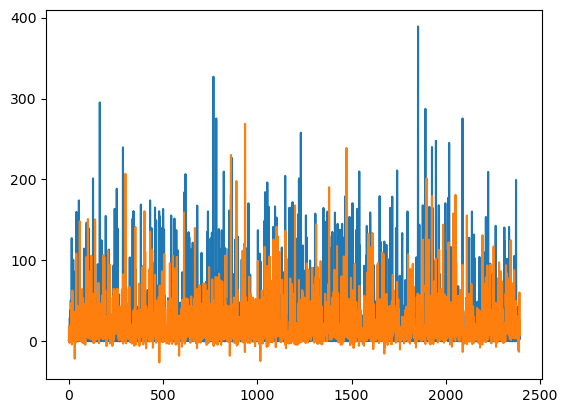

In [30]:
plt.plot(y_test)
plt.plot(y_test_pred)




Optimizations

In [ ]:
# # Create a method that creates a new Sequential model with hyperparameter options
# def create_model(hp):
#     neural_network = tf.keras.models.Sequential()

#     # Allow kerastuner to decide which activation function to use in hidden layers
#     activation = hp.Choice('activation','relu')
    
#     # Allow kerastuner to decide number of neurons in first layer
#     neural_network.add(tf.keras.layers.Dense(units=hp.Int('first_units',
#         min_value=1,
#         max_value=100,
#         step=2), activation=activation, input_dim=len(X_train[0])))

#     # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
#     for i in range(hp.Int('num_layers', 1, 5)):
#         neural_network.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
#             min_value=1,
#             max_value=100,
#             step=1),
#             activation=activation))
    
#     neural_network.add(tf.keras.layers.Dense(units=1, activation="relu"))

#     # Compile the model
#     neural_network.compile(loss="mean_squared_error", optimizer='adam', metrics=['mean_squared_error'])
    
#     return neural_network

In [ ]:
# # Create a callback that saves the model's weights every 5 epoch

# # Import checkpoint dependencies
# import os
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the checkpoint path and filenames
# os.makedirs("Checkpoints/",exist_ok=True)
# checkpoint_path = "Checkpoints/weights.{epoch:02d}.hdf5"
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1,
#     save_weights_only=True,
#     save_freq='epoch',
#     period=5)

In [ ]:
# # Train the model
# fit_model = neural_network.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback], batch_size=2048)

In [ ]:
# # Evaluate the model using the test data
# model_loss, model_accuracy = neural_network.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")